In [41]:
from SimPEG import Mesh, Maps
import numpy as np
from matplotlib.colors import LogNorm
from simpegem1d import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, 
    get_vertical_discretization_time, run_simulation_TD
)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Seting up a 2D mesh and model

In [42]:
from simpegem1d import skytem_HM_2015
wave = skytem_HM_2015()

In [43]:
time = np.logspace(-6, -3, 21)
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)
time_input_currents = wave.current_times[-7:]
input_currents = wave.currents[-7:]


In [44]:
from scipy.spatial import Delaunay
def PolygonInd(mesh, pts):
    hull = Delaunay(pts)
    inds = hull.find_simplex(mesh.gridCC)>=0
    return inds

In [45]:
n_sounding = 20
dx = 20.
hx = np.ones(n_sounding) * dx
mesh = Mesh.TensorMesh([hx, hz], x0='00')
inds =  mesh.gridCC[:,1]<25
inds_1 =  mesh.gridCC[:,1]<50
sigma = np.ones(mesh.nC) * 1./100.
sigma[inds_1] = 1./10.
sigma[inds] = 1./50.
x0 = np.r_[0., 75.]
x1 = np.r_[400., 75.]
x2 = np.r_[400., 90.]
x3 = np.r_[0., 125.]
pts = np.vstack((x0, x1, x2, x3, x0))
# poly_inds = PolygonInd(mesh, pts)
# sigma[poly_inds] = 0.1

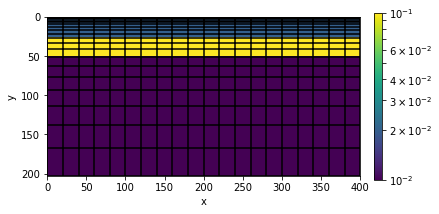

In [46]:
cb = plt.colorbar(
    mesh.plotImage(sigma, grid=True, pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.025, pad=0.04    
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect('equal')

In [47]:
x = mesh.vectorCCx
y = np.zeros_like(x)
z = np.ones_like(x) * 30.
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, z-30.].astype(float)

In [48]:
mapping = Maps.ExpMap(mesh)

In [49]:
%%time
field_type = 'secondary'
rx_type = 'dBzdt'
src_type = 'CircularLoop'
offset = np.r_[8.]
a = 13.
n_pulse = 1
base_frequency = 20.
jacSwitch = True
wave_type = 'stepoff'
i=0
sigma_i = np.ones(19) * 1e-2
args = rx_locations[i,:], src_locations[i,:], topo[i,:], hz, time, field_type, rx_type, src_type, wave_type, offset, a, time_input_currents, input_currents, n_pulse, base_frequency, sigma_i, jacSwitch
resp_sim = run_simulation_TD(args)

CPU times: user 1.09 s, sys: 9.52 ms, total: 1.1 s
Wall time: 1.13 s


In [50]:
survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    topo = topo,
    time = time,
    src_type = "VMD",
    rx_type = "dBzdt",    
    field_type = 'secondary',
    wave_type = 'stepoff',    
    offset = np.r_[8.],    
    a = 13.,
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    n_pulse = 1,
    base_frequency = 20.,
)
prob = GlobalEM1DProblemTD(mesh, sigmaMap=mapping, hz=hz, parallel=True, n_cpu=2)
prob.pair(survey)

>> Use multiprocessing for parallelization
>> n_cpu: 2


In [37]:
m = np.log(sigma)

In [38]:
pred = survey.dpred(m)

In [39]:
%%time 
prob.Jtvec(m, pred)

CPU times: user 23.6 ms, sys: 27.9 ms, total: 51.5 ms
Wall time: 17 s


array([ 4.43283364e-15,  2.88185652e-15,  2.83344128e-16, -2.33025580e-15,
       -3.36705078e-15, -2.47805070e-15, -1.12486865e-15, -3.83714206e-16,
       -1.19773169e-16, -3.60645704e-17, -1.04182462e-17, -2.87157832e-18,
       -7.52818340e-19, -1.87482195e-19, -4.44052171e-20, -1.00266417e-20,
       -2.16351023e-21, -4.47757133e-22, -1.10473834e-22,  4.43283364e-15,
        2.88185652e-15,  2.83344128e-16, -2.33025580e-15, -3.36705078e-15,
       -2.47805070e-15, -1.12486865e-15, -3.83714206e-16, -1.19773169e-16,
       -3.60645704e-17, -1.04182462e-17, -2.87157832e-18, -7.52818340e-19,
       -1.87482195e-19, -4.44052171e-20, -1.00266417e-20, -2.16351023e-21,
       -4.47757133e-22, -1.10473834e-22,  4.43283364e-15,  2.88185652e-15,
        2.83344128e-16, -2.33025580e-15, -3.36705078e-15, -2.47805070e-15,
       -1.12486865e-15, -3.83714206e-16, -1.19773169e-16, -3.60645704e-17,
       -1.04182462e-17, -2.87157832e-18, -7.52818340e-19, -1.87482195e-19,
       -4.44052171e-20, -

In [71]:
from simpegem1d import EM1DSurveyTD, EM1D
mesh_1d = Mesh.TensorMesh([mesh.hy], x0=[0.])
depth = -mesh_1d.gridN[:-1]
m_1d = np.log(prob.Sigma[0,:])
FDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 30.]),
    src_location = np.array([0., 0., 30.]),
    topo= np.array([0., 0., 0.]),
    time = time,
    depth=depth,
    src_type = "VMD",
    rx_type = "dBzdt",    
    field_type = 'secondary',
    wave_type = 'stepoff',    
    offset = np.r_[8.],    
    a = 13.,
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    n_pulse = 1,
    base_frequency = 20.
)
prob_1d = EM1D(
    mesh_1d, sigmaMap=Maps.ExpMap(mesh_1d), jacSwitch=False,
    chi=np.zeros(FDsurvey.n_layer)
)
if prob_1d.ispaired:
    prob_1d.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob_1d.pair(FDsurvey)
resp = FDsurvey.dpred(m_1d)

In [72]:
pred.shape

(420,)

In [73]:
PRED = pred.reshape(( prob.n_sounding, survey.n_time))

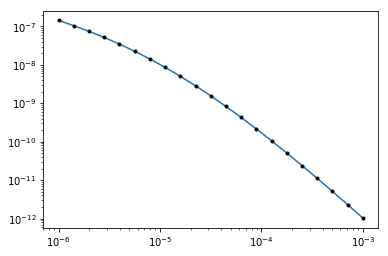

In [75]:
plt.loglog(time, -PRED[0,:])
plt.loglog(time, -resp, 'k.')
# plt.loglog(time, -resp_sim, 'rx')